## Imports


In [ ]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.models import mobilenet_v2
from PIL import Image

from transformers import DistilBertTokenizerFast, DistilBertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

/home/avinna/Personal/NN-DL/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configuration


In [2]:
from config import CHECKPOINT_DIR, DATA_ROOT

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 15

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

## Load Dataset


In [3]:
df = pd.read_csv(f"{DATA_ROOT}/ocr_ads_cleaned.csv")

# Drop rows with missing or empty required fields
df = df.dropna(subset=["image_path", "filtered_text", "label"])

# Also remove rows where filtered_text is empty string
df = df[df["filtered_text"].str.strip() != ""].reset_index(drop=True)

df.head()

,image_path,slogan_text,label,clean_text,filtered_text
0,madverse_data/OnlineAds/baby_products/baby_ess...,chicco baby moments F0 R EVERYDAY MOMENTS 0 F ...,baby_products,chicco moments everyday moments parabens free ...,chicco moments everyday moments parabens free
1,madverse_data/OnlineAds/baby_products/baby_ess...,"""No language can express the power and beauty,...",baby_products,language can express the power and beauty and ...,language can express the power and beauty and ...
2,madverse_data/OnlineAds/baby_products/baby_ess...,(chicco) Baby Care for New-age Parents like Yo...,baby_products,chicco care for new age parents like you momen...,chicco care for new age parents like you momen...
3,madverse_data/OnlineAds/baby_products/baby_ess...,#PARTNER iN PARENting Complete Protection for ...,baby_products,partner parenting complete protection for your...,partner complete protection for your minutes e...
4,madverse_data/OnlineAds/baby_products/baby_ess...,C (chicco) MOMENT OF DeeP CLEANSING AND NOURIS...,baby_products,chicco moment deep cleansing and nourishment c...,chicco moment deep cleansing and nourishment c...


## Encode Labels


In [4]:
le = LabelEncoder()
df["label_id"] = le.fit_transform(df["label"])

NUM_CLASSES = len(le.classes_)
print("Classes:", le.classes_)

Classes: ['baby_products' 'body_wear' 'cosmetics' 'drinks' 'electronics'
 'financial_institutions' 'food' 'home_essentials' 'sports' 'travel'
 'vehicles']


## Train Test Split

In [5]:
train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df["label_id"], random_state=42
)

## Image Transformations


In [6]:
img_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

## Save Model Utility

In [ ]:
def save_model(
    model,
    optimizer,
    epoch,
    num_classes,
    le,
    filename,
    train_losses,
    test_losses,
    text_model_str=None,
    image_encoder_str=None,
    text_encoder_str=None,
):
    """Save the model checkpoint along with training metadata."""
    data = {
        "model_state_dict": model.state_dict(),
        "num_classes": num_classes,
        "label_classes": le.classes_.tolist(),
        "epoch": epoch,
        "optimizer_state_dict": optimizer.state_dict(),
        "train_losses": train_losses,
        "test_losses": test_losses,
    }

    if text_model_str:
        data["text_model"] = text_model_str

    if image_encoder_str:
        data["image_encoder"] = image_encoder_str

    if text_encoder_str:
        data["text_encoder"] = text_encoder_str

    torch.save(data, filename)

    print(f"Saved model to {filename}")

## Training Utilities


In [ ]:
def train_epoch(model, loader, optimizer, scaler, criterion, device, mode="image"):
    """Train the model for one epoch with mixed precision."""
    model.train()
    correct, total_loss = 0, 0

    for batch in loader:
        optimizer.zero_grad()

        if mode == "image":
            x, y = batch
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            with torch.amp.autocast(device):
                out = model(x)

        elif mode == "text":
            input_ids, attention_mask, y = batch
            input_ids = input_ids.to(device, non_blocking=True)
            attention_mask = attention_mask.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            with torch.amp.autocast(device):
                embeddings = distilbert(
                    input_ids=input_ids, attention_mask=attention_mask
                ).last_hidden_state[:, 0, :]
                out = model(embeddings)
        loss = criterion(out, y)

        # Scale the loss and do backward
        scaler.scale(loss).backward()
        # Step optimizer with scaled gradients
        scaler.step(optimizer)
        # Update the scaler for next iteration
        scaler.update()

        total_loss += loss.item()
        correct += (out.argmax(1) == y).sum().item()

    return total_loss / len(loader), correct / len(loader.dataset)


def eval_epoch(model, loader, criterion, device, mode="image"):
    """Evaluate the model for one epoch."""
    model.eval()
    correct, total_loss = 0, 0

    with torch.no_grad():
        for batch in loader:
            if mode == "image":
                x, y = batch
                x = x.to(device, non_blocking=True)
                y = y.to(device, non_blocking=True)
                with torch.amp.autocast("cuda"):
                    out = model(x)

            elif mode == "text":
                input_ids, attention_mask, y = batch
                input_ids = input_ids.to(device, non_blocking=True)
                attention_mask = attention_mask.to(device, non_blocking=True)
                y = y.to(device, non_blocking=True)
                with torch.amp.autocast("cuda"):
                    text_emb = distilbert(
                        input_ids=input_ids, attention_mask=attention_mask
                    ).last_hidden_state[:, 0, :]
                    out = model(text_emb)

            # images, labels = images.to(device), labels.to(device)
            # out = model(images)
            correct += (out.argmax(1) == y).sum().item()
            loss = criterion(out, y)
            total_loss += loss.item()

    return total_loss / len(loader), correct / len(loader.dataset)


def plot_training_curves(train_losses, val_losses=None, title="Training Progress"):
    """Plot training and validation loss curves."""
    plt.figure(figsize=(10, 5))
    epochs = range(1, len(train_losses) + 1)

    plt.plot(epochs, train_losses, "b-", label="Training Loss", linewidth=2)
    if val_losses:
        plt.plot(epochs, val_losses, "r-", label="Validation Loss", linewidth=2)

    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.title(title, fontsize=14, fontweight="bold")
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Image-Only Model (MobileNetV2)


## Image Dataset


In [ ]:
class ImageDataset(Dataset):
    """Custom dataset for loading images and their labels."""
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["image_path"]).convert("RGB")
        img = img_transform(img)
        label = row["label_id"]
        return img, label

## MobileNetV2 Image Model


In [ ]:
class ImageModel(nn.Module):
    """Image classification model with MobileNetV2 backbone and custom classifier."""
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = mobilenet_v2(weights="IMAGENET1K_V1")
        self.backbone.classifier = nn.Identity()  # 1280-d
        self.classifier = nn.Sequential(
            nn.Linear(1280, 512),
            nn.BatchNorm1d(512),  # Stabilizes learning
            nn.ReLU(),
            nn.Dropout(0.3),  # Prevent overfitting
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),  # Stabilizes learning
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        feat = self.backbone(x)
        return self.classifier(feat)

## Train Image-Only Model


In [ ]:
CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, "mobilenetv2_image_model.pth")

train_loader = DataLoader(
    ImageDataset(train_df),
    batch_size=64,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True,
    shuffle=True,
)
val_loader = DataLoader(
    ImageDataset(val_df),
    batch_size=64,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True,
)

image_model = ImageModel(NUM_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(image_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
scaler = torch.amp.GradScaler(DEVICE)

start_epoch = 0

train_losses, test_losses = [], []

if os.path.exists(CHECKPOINT_PATH):
    print("Image model checkpoint found. Loading weights...")

    ckpt = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
    image_model.load_state_dict(ckpt["model_state_dict"])
    optimizer.load_state_dict(ckpt["optimizer_state_dict"])
    train_losses = ckpt.get("train_losses", [])
    test_losses = ckpt.get("test_losses", [])
    start_epoch = ckpt["epoch"]
else:
    print("No checkpoint found. Starting training...")

for epoch in range(start_epoch, EPOCHS):
    train_loss, train_acc = train_epoch(
        image_model, train_loader, optimizer, scaler, criterion, DEVICE
    )
    train_losses.append(train_loss)

    test_loss, val_acc = eval_epoch(image_model, val_loader, criterion, DEVICE)
    test_losses.append(test_loss)

    print(
        f"[Image] Epoch {epoch + 1}/{EPOCHS} | "
        f"Loss: {train_loss:.3f} | "
        f"Train Acc: {train_acc:.3f} | "
        f"Val Acc: {val_acc:.3f}"
    )

    # Save trained model
    save_model(
        image_model,
        optimizer,
        epoch + 1,
        NUM_CLASSES,
        le,
        CHECKPOINT_PATH,
        train_losses,
        test_losses,
    )

No checkpoint found. Starting training...
[Image] Epoch 1/15 | Loss: 1.168 | Train Acc: 0.674 | Val Acc: 0.765
Saved model to checkpoints/mobilenetv2_image_model.pth
[Image] Epoch 2/15 | Loss: 0.627 | Train Acc: 0.828 | Val Acc: 0.809
Saved model to checkpoints/mobilenetv2_image_model.pth
[Image] Epoch 3/15 | Loss: 0.382 | Train Acc: 0.901 | Val Acc: 0.832
Saved model to checkpoints/mobilenetv2_image_model.pth
[Image] Epoch 4/15 | Loss: 0.218 | Train Acc: 0.948 | Val Acc: 0.837
Saved model to checkpoints/mobilenetv2_image_model.pth
[Image] Epoch 5/15 | Loss: 0.127 | Train Acc: 0.973 | Val Acc: 0.837
Saved model to checkpoints/mobilenetv2_image_model.pth
[Image] Epoch 6/15 | Loss: 0.077 | Train Acc: 0.986 | Val Acc: 0.833
Saved model to checkpoints/mobilenetv2_image_model.pth
[Image] Epoch 7/15 | Loss: 0.056 | Train Acc: 0.991 | Val Acc: 0.841
Saved model to checkpoints/mobilenetv2_image_model.pth
[Image] Epoch 8/15 | Loss: 0.045 | Train Acc: 0.991 | Val Acc: 0.845
Saved model to checkp

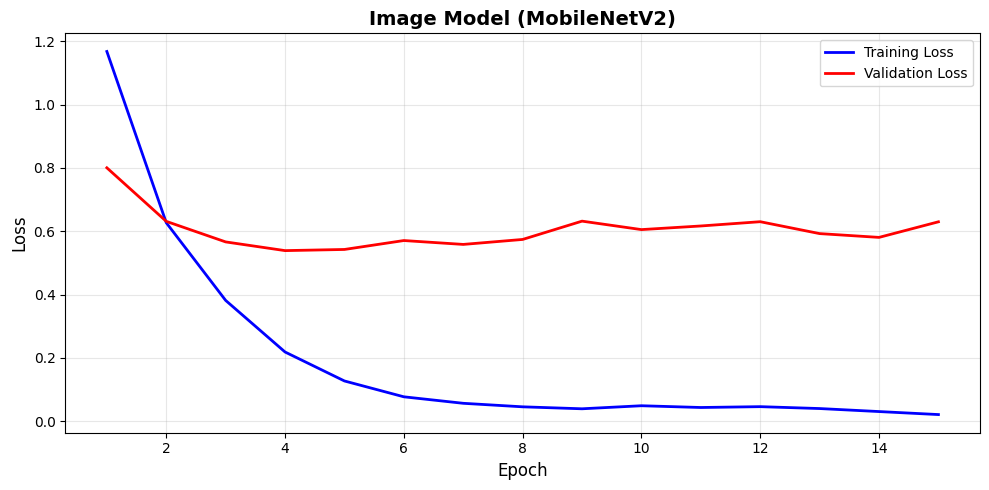

In [12]:
plot_training_curves(train_losses, test_losses, title="Image Model (MobileNetV2)")

# Text-Only Model (DistilBERT)


## Load DistilBERT


In [13]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
distilbert = DistilBertModel.from_pretrained("distilbert-base-uncased")
distilbert.eval()
distilbert.to(DEVICE)

TEXT_DIM = 768

## Text Dataset


In [ ]:
class TextDataset(Dataset):
    """Custom dataset for loading text data and their labels."""
    def __init__(self, df, tokenizer, max_len=32):
        self.texts = df["filtered_text"].tolist()
        self.labels = df["label_id"].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        """Get tokenized text and label for the given index."""
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )

        return (
            enc["input_ids"].squeeze(0),  # CPU
            enc["attention_mask"].squeeze(0),  # CPU
            self.labels[idx],
        )

## Text Classifier


In [ ]:
class TextModel(nn.Module):
    """Text classification model using DistilBERT embeddings and custom classifier."""
    def __init__(self, num_classes):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(TEXT_DIM, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        return self.fc(x)

## Train Text-Only Model


In [ ]:
CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, "distilbert_text_model.pth")
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

train_loader = DataLoader(TextDataset(train_df, tokenizer), batch_size=64, shuffle=True)
val_loader = DataLoader(
    TextDataset(val_df, tokenizer),
    batch_size=64,
)

text_model = TextModel(NUM_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(text_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
scaler = torch.amp.GradScaler(DEVICE)

start_epoch = 0

train_losses, test_losses = [], []

if os.path.exists(CHECKPOINT_PATH):
    print("Text model checkpoint found. Loading weights...")

    ckpt = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
    text_model.load_state_dict(ckpt["model_state_dict"])
    optimizer.load_state_dict(ckpt["optimizer_state_dict"])
    train_losses = ckpt.get("train_losses", [])
    test_losses = ckpt.get("test_losses", [])
    start_epoch = ckpt["epoch"]
else:
    print("No checkpoint found. Starting training...")

for epoch in range(start_epoch, EPOCHS):
    train_loss, acc = train_epoch(
        text_model, train_loader, optimizer, scaler, criterion, DEVICE, mode="text"
    )
    train_losses.append(train_loss)

    test_loss, val_acc = eval_epoch(
        text_model, val_loader, criterion, DEVICE, mode="text"
    )
    test_losses.append(test_loss)

    print(
        f"[Text] Epoch {epoch+1} | Loss {train_loss:.3f} | Train {acc:.3f} | Val {val_acc:.3f}"
    )

    save_model(
        text_model,
        optimizer,
        epoch + 1,
        NUM_CLASSES,
        le,
        CHECKPOINT_PATH,
        train_losses,
        test_losses,
        text_model_str="distilbert-base-uncased",
    )

No checkpoint found. Starting training...
[Text] Epoch 1 | Loss 1.443 | Train 0.529 | Val 0.607
Saved model to checkpoints/distilbert_text_model.pth
[Text] Epoch 2 | Loss 1.150 | Train 0.615 | Val 0.622
Saved model to checkpoints/distilbert_text_model.pth
[Text] Epoch 3 | Loss 1.067 | Train 0.648 | Val 0.668
Saved model to checkpoints/distilbert_text_model.pth
[Text] Epoch 4 | Loss 1.015 | Train 0.660 | Val 0.669
Saved model to checkpoints/distilbert_text_model.pth
[Text] Epoch 5 | Loss 0.968 | Train 0.675 | Val 0.684
Saved model to checkpoints/distilbert_text_model.pth
[Text] Epoch 6 | Loss 0.939 | Train 0.686 | Val 0.692
Saved model to checkpoints/distilbert_text_model.pth
[Text] Epoch 7 | Loss 0.906 | Train 0.697 | Val 0.703
Saved model to checkpoints/distilbert_text_model.pth
[Text] Epoch 8 | Loss 0.881 | Train 0.709 | Val 0.706
Saved model to checkpoints/distilbert_text_model.pth
[Text] Epoch 9 | Loss 0.855 | Train 0.713 | Val 0.713
Saved model to checkpoints/distilbert_text_model

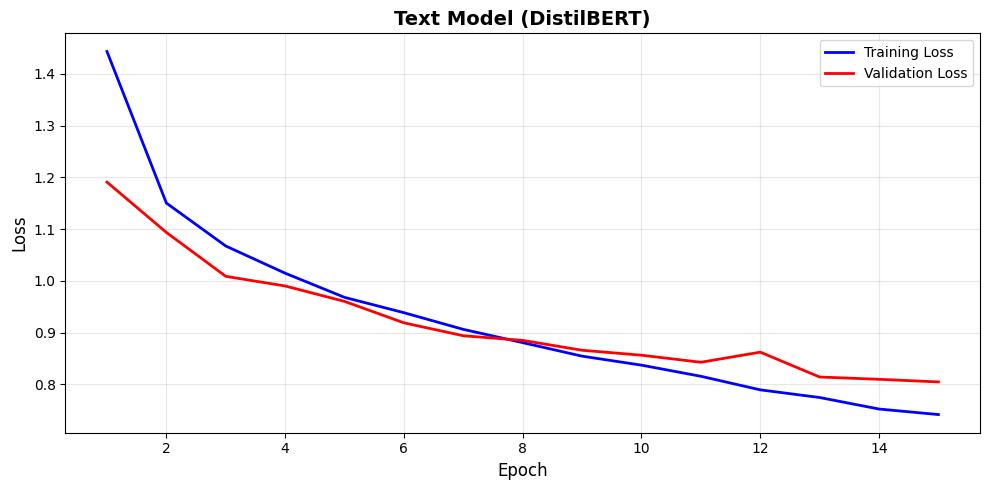

In [17]:
plot_training_curves(train_losses, test_losses, title="Text Model (DistilBERT)")

# Late Fusion (MobileNetV2 + DistilBERT)


## Multimodal Dataset


In [ ]:
class MultiModalDataset(Dataset):
    """Custom dataset for loading image and text data together."""
    def __init__(self, df, tokenizer, img_transform=None, max_len=32):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.img_transform = img_transform
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        """Get image, tokenized text, and label for the given index."""
        row = self.df.iloc[idx]

        img = Image.open(row["image_path"]).convert("RGB")
        img = img_transform(img)

        enc = tokenizer(
            row["filtered_text"],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )

        return (
            img,
            enc["input_ids"].squeeze(0),
            enc["attention_mask"].squeeze(0),
            row["label_id"],
        )

## Fusion Model


In [ ]:
class FusionModel(nn.Module):
    """Multi-modal fusion model combining image and text features."""
    def __init__(self, image_model, text_model, text_dim=768, num_classes=11):
        super().__init__()

        # Use of the pre-trained image model's backbone (1280-d output)
        self.image_encoder = image_model.backbone

        # Use of the pre-trained text model's classifier (outputs num_classes)
        # Extract features before the final layer
        self.text_encoder = text_model.fc[:-1]
        text_hidden_dim = 256  # Output of the first Linear layer after ReLU+Dropout

        # Fusion classifier (1280 from image + 256 from text)
        self.classifier = nn.Sequential(
            nn.Linear(1280 + text_hidden_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes),
        )

    def forward(self, img, input_ids, attention_mask, distilbert):
        # Image features from pre-trained backbone (1280-d)
        img_feat = self.image_encoder(img)

        # Text features from DistilBERT + pre-trained text model layers
        with torch.no_grad():  # Freeze DistilBERT
            text_emb = distilbert(
                input_ids=input_ids, attention_mask=attention_mask
            ).last_hidden_state[:, 0, :]

        # Pass through pre-trained text model layers (768 -> 256)
        text_feat = self.text_encoder(text_emb)

        # Late fusion via concatenation
        fused = torch.cat([img_feat, text_feat], dim=1)

        return self.classifier(fused)

## Train Fusion Model


In [32]:
CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, "multimodal_fusion_model.pth")

train_loader = DataLoader(
    MultiModalDataset(train_df, tokenizer, img_transform), batch_size=32, shuffle=True
)
val_loader = DataLoader(
    MultiModalDataset(val_df, tokenizer, img_transform), batch_size=32
)

# Freeze pre-trained image model
image_model.eval()
for param in image_model.parameters():
    param.requires_grad = False

# Freeze pre-trained text model
text_model.eval()
for param in text_model.parameters():
    param.requires_grad = False

# Initialize fusion model using both pre-trained models
fusion_model = FusionModel(
    image_model=image_model,
    text_model=text_model,
    text_dim=TEXT_DIM,
    num_classes=NUM_CLASSES,
).to(DEVICE)

optimizer = torch.optim.Adam(fusion_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
scaler = torch.amp.GradScaler(DEVICE)

start_epoch = 0
train_losses, test_losses = [], []

if os.path.exists(CHECKPOINT_PATH):
    print("Fusion model checkpoint found. Loading weights...")
    ckpt = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
    fusion_model.load_state_dict(ckpt["model_state_dict"])
    optimizer.load_state_dict(ckpt["optimizer_state_dict"])
    train_losses = ckpt.get("train_losses", [])
    test_losses = ckpt.get("test_losses", [])
    start_epoch = ckpt["epoch"]
else:
    print("No checkpoint found. Starting training...")

for epoch in range(start_epoch, EPOCHS):
    fusion_model.train()
    correct, train_loss = 0, 0

    for img, input_ids, attention_mask, labels in train_loader:
        img, input_ids, attention_mask, labels = (
            img.to(DEVICE),
            input_ids.to(DEVICE),
            attention_mask.to(DEVICE),
            labels.to(DEVICE),
        )
        optimizer.zero_grad()

        with torch.amp.autocast(DEVICE):
            out = fusion_model(img, input_ids, attention_mask, distilbert)
            loss = criterion(out, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()
        correct += (out.argmax(1) == labels).sum().item()

    train_acc = correct / len(train_df)
    train_losses.append(train_loss / len(train_loader))

    fusion_model.eval()
    val_correct, test_loss = 0, 0
    with torch.no_grad():
        for img, input_ids, attention_mask, labels in val_loader:
            img, input_ids, attention_mask, labels = (
                img.to(DEVICE),
                input_ids.to(DEVICE),
                attention_mask.to(DEVICE),
                labels.to(DEVICE),
            )
            out = fusion_model(img, input_ids, attention_mask, distilbert)
            loss = criterion(out, labels)
            test_loss += loss.item()
            val_correct += (out.argmax(1) == labels).sum().item()

    test_losses.append(test_loss / len(val_loader))

    print(
        f"[Fusion] Epoch {epoch+1} | Train {correct/len(train_df):.3f} | Val {val_correct/len(val_df):.3f}"
    )

    save_model(
        fusion_model,
        optimizer,
        epoch + 1,
        NUM_CLASSES,
        le,
        CHECKPOINT_PATH,
        train_losses,
        test_losses,
        image_encoder_str="mobilenet_v2",
        text_encoder_str="distilbert-base-uncased",
    )

No checkpoint found. Starting training...
[Fusion] Epoch 1 | Train 0.952 | Val 0.865
Saved model to checkpoints/multimodal_fusion_model.pth
[Fusion] Epoch 2 | Train 0.992 | Val 0.871
Saved model to checkpoints/multimodal_fusion_model.pth
[Fusion] Epoch 3 | Train 0.993 | Val 0.869
Saved model to checkpoints/multimodal_fusion_model.pth
[Fusion] Epoch 4 | Train 0.995 | Val 0.868
Saved model to checkpoints/multimodal_fusion_model.pth
[Fusion] Epoch 5 | Train 0.995 | Val 0.876
Saved model to checkpoints/multimodal_fusion_model.pth
[Fusion] Epoch 6 | Train 0.995 | Val 0.876
Saved model to checkpoints/multimodal_fusion_model.pth
[Fusion] Epoch 7 | Train 0.996 | Val 0.878
Saved model to checkpoints/multimodal_fusion_model.pth
[Fusion] Epoch 8 | Train 0.997 | Val 0.877
Saved model to checkpoints/multimodal_fusion_model.pth
[Fusion] Epoch 9 | Train 0.996 | Val 0.869
Saved model to checkpoints/multimodal_fusion_model.pth
[Fusion] Epoch 10 | Train 0.997 | Val 0.873
Saved model to checkpoints/multi

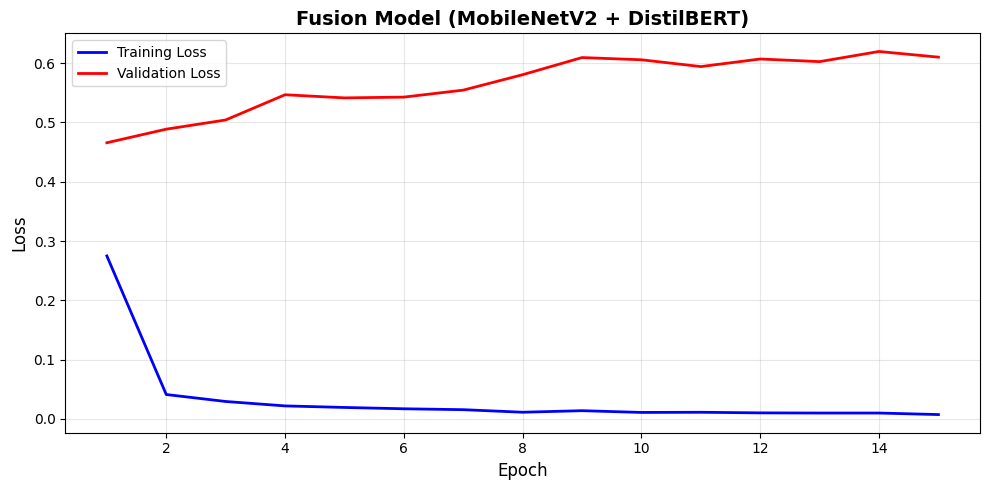

In [21]:
plot_training_curves(train_losses, test_losses, title="Fusion Model (MobileNetV2 + DistilBERT)")

## 8. Model Evaluation & Results Analysis

This section provides comprehensive evaluation metrics including confusion matrices, classification reports, and accuracy comparisons across all three models.

### 8.1 Evaluation Helper Functions

In [22]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import numpy as np


def evaluate_image_model(model, loader, device):
    """Evaluate image model and return predictions and true labels"""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)


def evaluate_text_model(model, loader, device, distilbert_model):
    """Evaluate text model and return predictions and true labels"""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for input_ids, attention_mask, labels in loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            text_emb = distilbert_model(
                input_ids=input_ids, attention_mask=attention_mask
            ).last_hidden_state[:, 0, :]
            outputs = model(text_emb)

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)


def evaluate_fusion_model(model, loader, device, distilbert_model):
    """Evaluate fusion model and return predictions and true labels"""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for img, input_ids, attention_mask, labels in loader:
            img = img.to(device)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(img, input_ids, attention_mask, distilbert_model)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)


def plot_confusion_matrix(y_true, y_pred, class_names, title):
    """Plot confusion matrix with proper formatting"""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(14, 12))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(title, fontsize=14, fontweight="bold")
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.xticks(rotation=45, ha="right", fontsize=9)
    plt.yticks(rotation=0, fontsize=9)
    plt.tight_layout()

    plt.show()


def print_classification_report(y_true, y_pred, class_names, model_name):
    """Print formatted classification report"""
    print(f"\n{'='*60}")
    print(f"Classification Report: {model_name}")
    print("=" * 60)
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    print(report)
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print("=" * 60)
    return accuracy

### 8.2 Load Trained Models for Evaluation

In [23]:
# Get class names from label encoder (le is already defined above)
class_names = list(le.classes_)
num_classes = len(class_names)

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

# Create validation data loaders for evaluation
val_loader_image = DataLoader(
    ImageDataset(val_df),
    batch_size=64,
    num_workers=2,
    pin_memory=True,
)

val_loader_text = DataLoader(
    TextDataset(val_df, tokenizer),
    batch_size=64,
)

val_loader_fusion = DataLoader(
    MultiModalDataset(val_df, tokenizer, img_transform),
    batch_size=32,
)

print("\nValidation loaders created for evaluation!")

Number of classes: 11
Class names: ['baby_products', 'body_wear', 'cosmetics', 'drinks', 'electronics', 'financial_institutions', 'food', 'home_essentials', 'sports', 'travel', 'vehicles']

Validation loaders created for evaluation!


### 8.3 Evaluate Image Model (MobileNetV2)

Evaluating Image Model (MobileNetV2)...



Classification Report: Image Model (MobileNetV2)
                        precision    recall  f1-score   support

         baby_products     0.8624    0.7581    0.8069       124
             body_wear     0.8142    0.8649    0.8388       385
             cosmetics     0.8091    0.7884    0.7986       430
                drinks     0.7778    0.7457    0.7614       460
           electronics     0.8848    0.8709    0.8777       573
financial_institutions     0.7188    0.8809    0.7916       235
                  food     0.8640    0.8734    0.8687      1193
       home_essentials     0.7263    0.7514    0.7386       173
                sports     0.7021    0.5593    0.6226        59
                travel     0.7391    0.6415    0.6869       212
              vehicles     0.9804    0.9772    0.9788       615

              accuracy                         0.8426      4459
             macro avg     0.8072    0.7920    0.7973      4459
          weighted avg     0.8431    0.8426    0.841

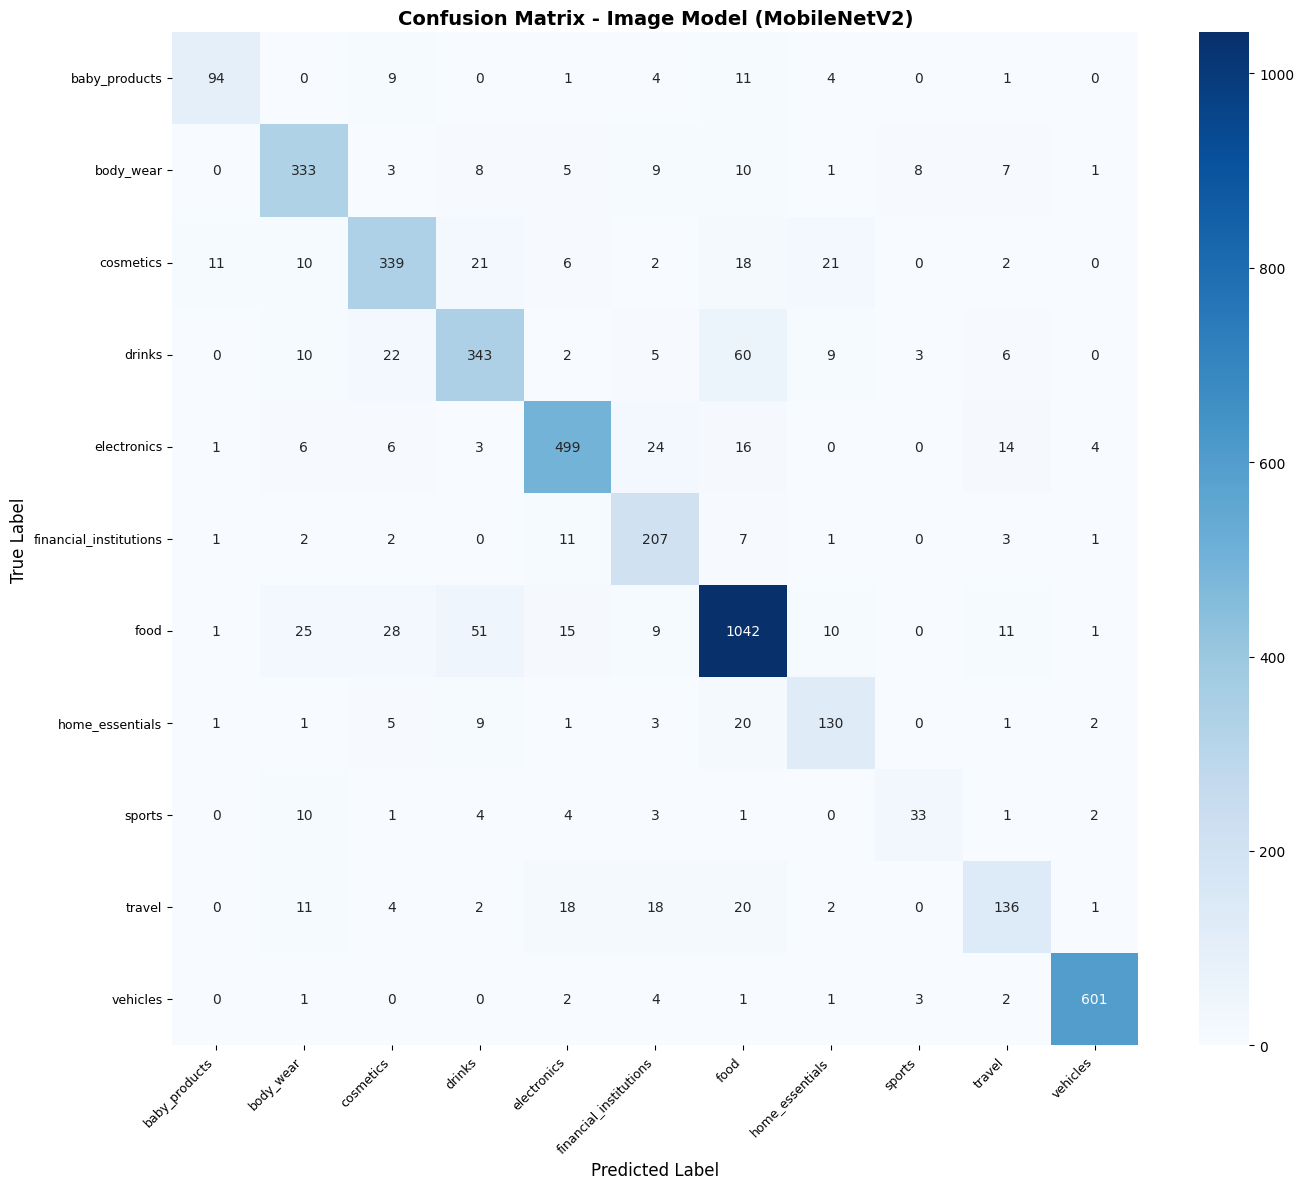

In [24]:
# Evaluate Image Model
print("Evaluating Image Model (MobileNetV2)...")
image_preds, image_labels = evaluate_image_model(image_model, val_loader_image, DEVICE)

# Classification Report
image_accuracy = print_classification_report(
    image_labels, image_preds, class_names, "Image Model (MobileNetV2)"
)

# Confusion Matrix
plot_confusion_matrix(
    image_labels,
    image_preds,
    class_names,
    title="Confusion Matrix - Image Model (MobileNetV2)",
)

### 8.4 Evaluate Text Model (DistilBERT)

Evaluating Text Model (DistilBERT)...

Classification Report: Text Model (DistilBERT)
                        precision    recall  f1-score   support

         baby_products     0.7895    0.6048    0.6849       124
             body_wear     0.8007    0.6260    0.7026       385
             cosmetics     0.7262    0.7093    0.7176       430
                drinks     0.5963    0.5587    0.5769       460
           electronics     0.8124    0.6876    0.7448       573
financial_institutions     0.7805    0.8170    0.7983       235
                  food     0.6805    0.8676    0.7627      1193
       home_essentials     0.7080    0.4624    0.5594       173
                sports     0.7000    0.4746    0.5657        59
                travel     0.8135    0.7406    0.7753       212
              vehicles     0.8290    0.8276    0.8283       615

              accuracy                         0.7340      4459
             macro avg     0.7488    0.6706    0.7015      4459
          weight

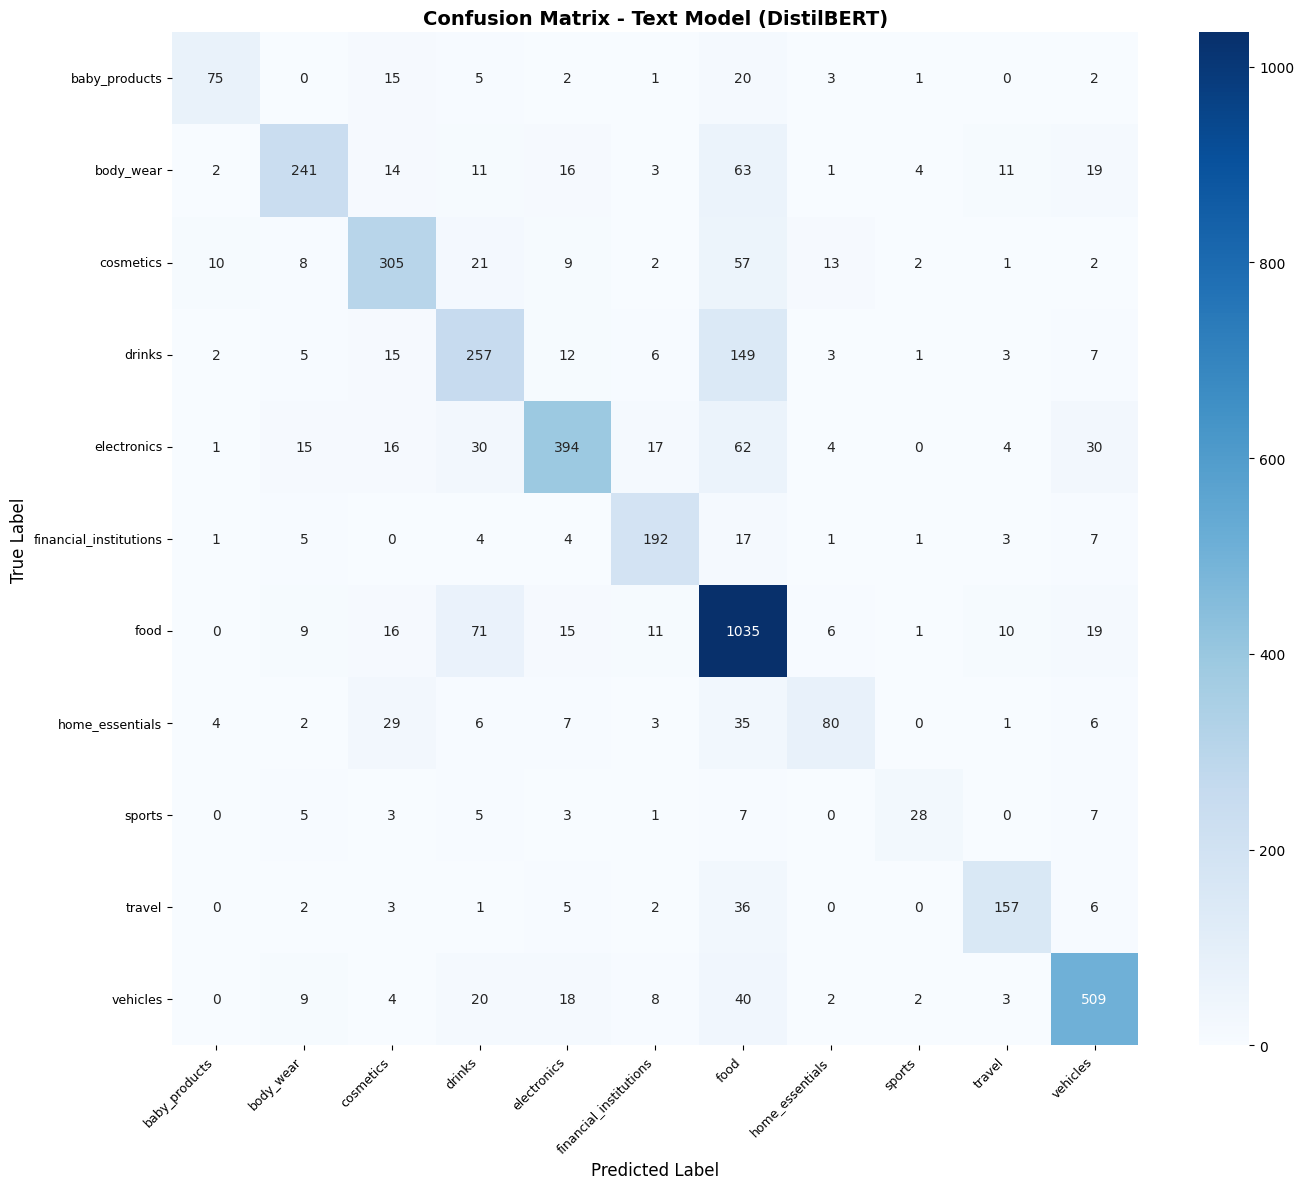

In [26]:
# Evaluate Text Model
print("Evaluating Text Model (DistilBERT)...")
text_preds, text_labels = evaluate_text_model(
    text_model, val_loader_text, DEVICE, distilbert
)

# Classification Report
text_accuracy = print_classification_report(
    text_labels, text_preds, class_names, "Text Model (DistilBERT)"
)

# Confusion Matrix
plot_confusion_matrix(
    text_labels,
    text_preds,
    class_names,
    title="Confusion Matrix - Text Model (DistilBERT)",
)

### 8.5 Evaluate Fusion Model (MobileNetV2 + DistilBERT)

Evaluating Fusion Model (MobileNetV2 + DistilBERT)...

Classification Report: Fusion Model (MobileNetV2 + DistilBERT)
                        precision    recall  f1-score   support

         baby_products     0.8729    0.8306    0.8512       124
             body_wear     0.8575    0.8909    0.8739       385
             cosmetics     0.8548    0.8628    0.8588       430
                drinks     0.8044    0.7957    0.8000       460
           electronics     0.9129    0.9145    0.9137       573
financial_institutions     0.8333    0.8936    0.8624       235
                  food     0.8926    0.8986    0.8956      1193
       home_essentials     0.7910    0.8092    0.8000       173
                sports     0.7391    0.5763    0.6476        59
                travel     0.8201    0.7311    0.7731       212
              vehicles     0.9853    0.9821    0.9837       615

              accuracy                         0.8796      4459
             macro avg     0.8513    0.8350    0

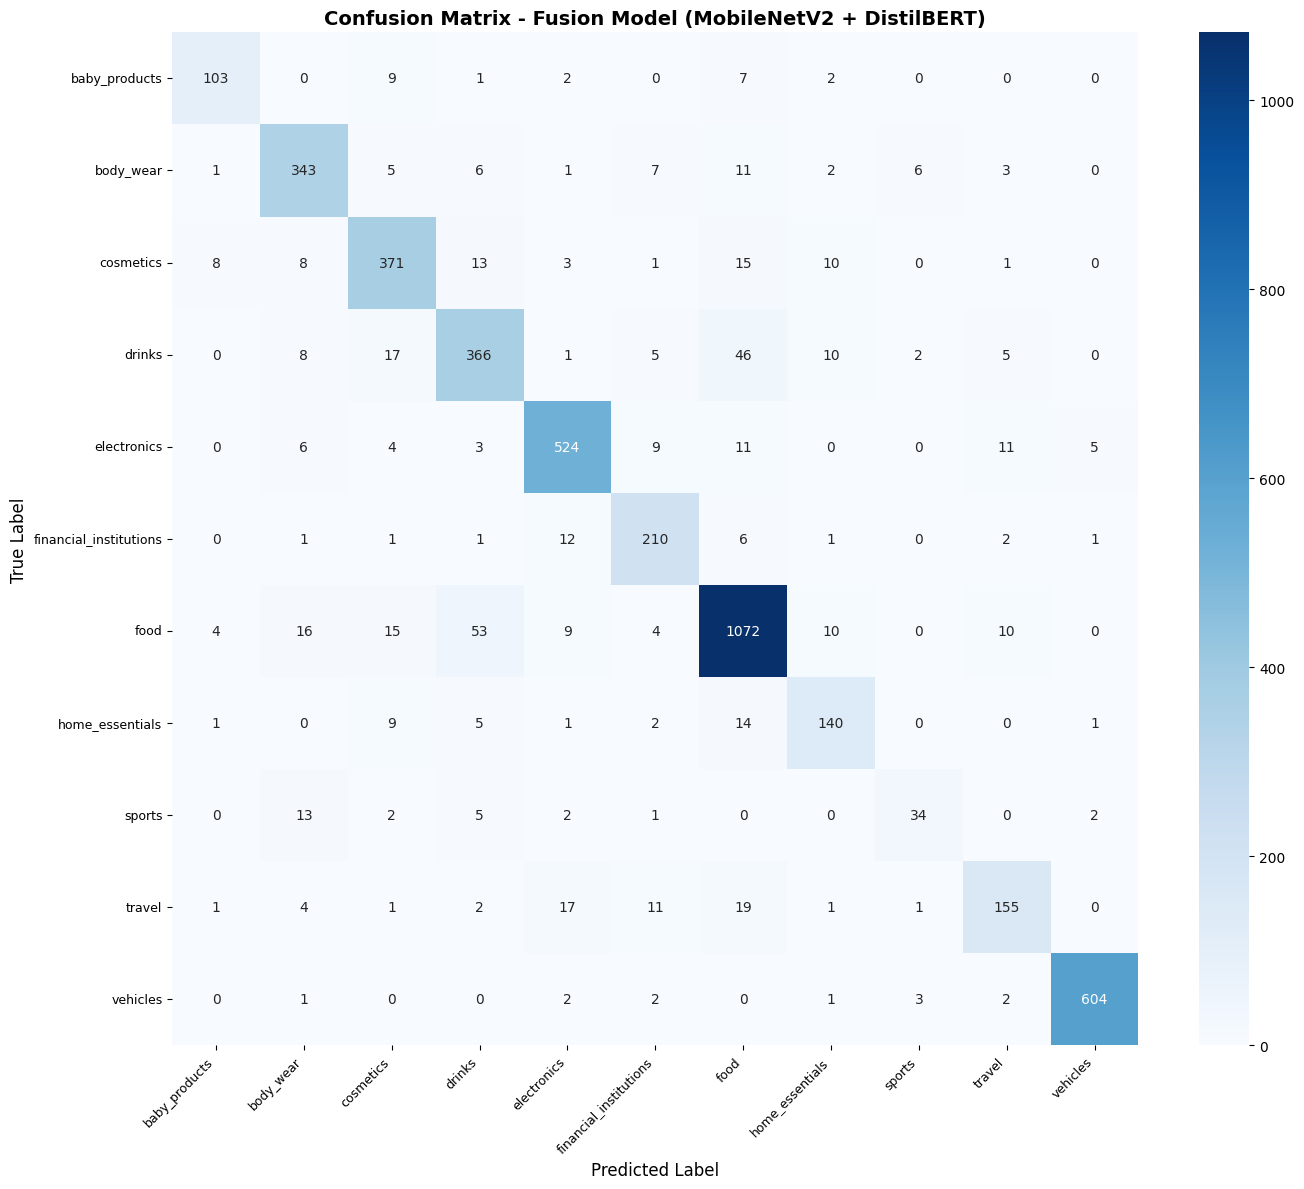

In [27]:
# Evaluate Fusion Model
print("Evaluating Fusion Model (MobileNetV2 + DistilBERT)...")
fusion_preds, fusion_labels = evaluate_fusion_model(
    fusion_model, val_loader_fusion, DEVICE, distilbert
)

# Classification Report
fusion_accuracy = print_classification_report(
    fusion_labels, fusion_preds, class_names, "Fusion Model (MobileNetV2 + DistilBERT)"
)

# Confusion Matrix
plot_confusion_matrix(
    fusion_labels,
    fusion_preds,
    class_names,
    title="Confusion Matrix - Fusion Model (MobileNetV2 + DistilBERT)",
)

### 8.6 Model Comparison Summary

MODEL PERFORMANCE COMPARISON
              Model  Accuracy (%) Parameters                     Input
Image (MobileNetV2)         84.26      ~3.5M            224×224 Images
  Text (DistilBERT)         73.40       ~67M OCR Text (max 128 tokens)
Fusion (Multimodal)         87.96     ~70.5M              Image + Text


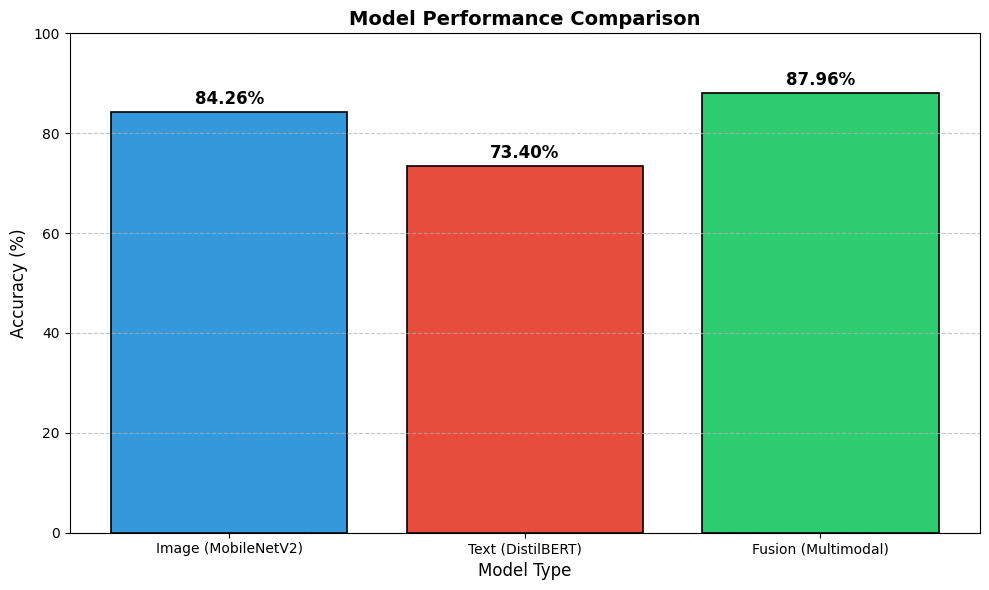

In [28]:
# Create comparison table
comparison_data = {
    "Model": ["Image (MobileNetV2)", "Text (DistilBERT)", "Fusion (Multimodal)"],
    "Accuracy (%)": [image_accuracy * 100, text_accuracy * 100, fusion_accuracy * 100],
    "Parameters": ["~3.5M", "~67M", "~70.5M"],
    "Input": ["224×224 Images", "OCR Text (max 128 tokens)", "Image + Text"],
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df["Accuracy (%)"] = comparison_df["Accuracy (%)"].round(2)

print("MODEL PERFORMANCE COMPARISON")
print(comparison_df.to_string(index=False))

# Visualize accuracy comparison
fig, ax = plt.subplots(figsize=(10, 6))
colors = ["#3498db", "#e74c3c", "#2ecc71"]
bars = ax.bar(
    comparison_df["Model"],
    comparison_df["Accuracy (%)"],
    color=colors,
    edgecolor="black",
    linewidth=1.2,
)

# Add value labels on bars
for bar, acc in zip(bars, comparison_df["Accuracy (%)"]):
    height = bar.get_height()
    ax.annotate(
        f"{acc:.2f}%",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=12,
        fontweight="bold",
    )

ax.set_xlabel("Model Type", fontsize=12)
ax.set_ylabel("Accuracy (%)", fontsize=12)
ax.set_title("Model Performance Comparison", fontsize=14, fontweight="bold")
ax.set_ylim(0, 100)
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

### 8.7 Sample Predictions Visualization

Display sample predictions from the fusion model showing the image, extracted text, true label, and predicted label.

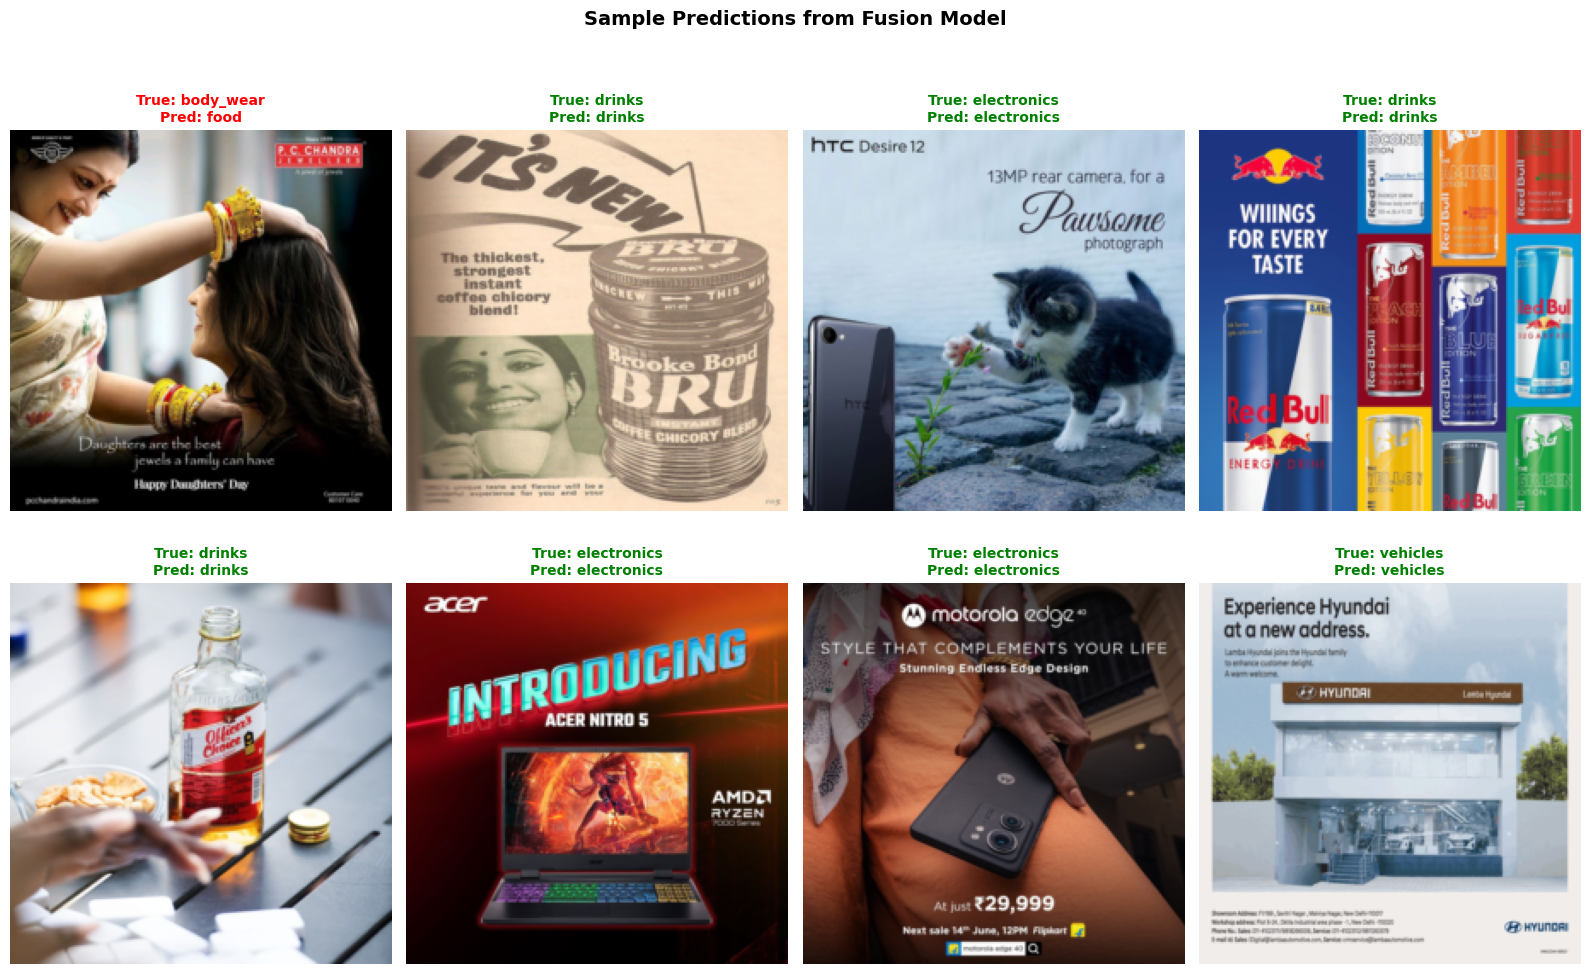

In [ ]:
def visualize_predictions(
    model, loader, device, class_names, distilbert_model, num_samples=8
):
    """Visualize sample predictions with images"""
    model.eval()

    # Get a batch of samples
    img, input_ids, attention_mask, labels = next(iter(loader))
    img = img.to(device)
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(img, input_ids, attention_mask, distilbert_model)
        _, preds = torch.max(outputs, 1)

    # Convert to numpy
    images_np = img.cpu().numpy()
    labels_np = labels.cpu().numpy()
    preds_np = preds.cpu().numpy()

    num_samples = random.sample(range(1, 33), 8)

    fig, axes = plt.subplots(2, 4, figsize=(16, 10))
    axes = axes.flatten()

    # Denormalize images for display
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    for _, idx in enumerate(num_samples):
        ax = axes[_]

        # Denormalize and transpose image
        image = images_np[idx - 1].transpose(1, 2, 0)
        image = std * image + mean
        image = np.clip(image, 0, 1)

        ax.imshow(image)

        true_label = class_names[labels_np[idx - 1]]
        pred_label = class_names[preds_np[idx - 1]]

        # Color code: green for correct, red for incorrect
        color = "green" if true_label == pred_label else "red"

        ax.set_title(
            f"True: {true_label}\nPred: {pred_label}",
            fontsize=10,
            color=color,
            fontweight="bold",
        )
        ax.axis("off")

    plt.suptitle(
        "Sample Predictions from Fusion Model", fontsize=14, fontweight="bold", y=1.02
    )
    plt.tight_layout()
    plt.show()


# Visualize predictions
visualize_predictions(fusion_model, val_loader_fusion, DEVICE, class_names, distilbert)

### 8.8 Misclassification Analysis

Analyze the most common misclassifications to understand model weaknesses.

In [31]:
def analyze_misclassifications(y_true, y_pred, class_names, top_n=10):
    """Analyze most common misclassification pairs"""
    # Find misclassified samples
    misclassified_mask = y_true != y_pred
    misclassified_true = y_true[misclassified_mask]
    misclassified_pred = y_pred[misclassified_mask]

    # Count misclassification pairs
    from collections import Counter

    pairs = list(zip(misclassified_true, misclassified_pred))
    pair_counts = Counter(pairs)

    print("TOP MISCLASSIFICATION PAIRS")
    print(f"{'True Label':<25} {'Predicted':<25} {'Count':<10}")

    for (true_idx, pred_idx), count in pair_counts.most_common(top_n):
        true_name = class_names[true_idx]
        pred_name = class_names[pred_idx]
        print(f"{true_name:<25} {pred_name:<25} {count:<10}")

    print(
        f"\nTotal Misclassifications: {len(pairs)} / {len(y_true)} ({len(pairs)/len(y_true)*100:.2f}%)"
    )

    return pair_counts


# Analyze misclassifications for Fusion Model
misclass_counts = analyze_misclassifications(fusion_labels, fusion_preds, class_names)

TOP MISCLASSIFICATION PAIRS
True Label                Predicted                 Count     
food                      drinks                    53        
drinks                    food                      46        
travel                    food                      19        
drinks                    cosmetics                 17        
travel                    electronics               17        
food                      body_wear                 16        
cosmetics                 food                      15        
food                      cosmetics                 15        
home_essentials           food                      14        
cosmetics                 drinks                    13        

Total Misclassifications: 537 / 4459 (12.04%)


### 8.9 Results Summary

Final summary of all experimental results and key findings.

In [32]:
# Final Results Summary
print("EXPERIMENTAL RESULTS SUMMARY\n")

print(
    f"""
DATASET:
  - Total Samples: {len(df):,}
  - Categories: {NUM_CLASSES}
  - Train/Test Split: 80/20

MODEL ARCHITECTURES:
  1. Image Model: MobileNetV2 (ImageNet pretrained) + Custom Classifier
  2. Text Model: DistilBERT + MLP Classifier  
  3. Fusion Model: Late Fusion (Concatenation) of Image + Text features

TRAINING CONFIGURATION:
  - Epochs: {EPOCHS}
  - Optimizer: Adam (lr=1e-4 for image, 1e-3 for text, 1e-4 for fusion)
  - Loss Function: CrossEntropyLoss
  - Batch Sizes: Image=64, Text=64, Fusion=32
  - Mixed Precision Training: Enabled

FINAL ACCURACIES:
  - Image Model (MobileNetV2):     {image_accuracy*100:.2f}%
  - Text Model (DistilBERT):       {text_accuracy*100:.2f}%
  - Fusion Model (Multimodal):     {fusion_accuracy*100:.2f}%

KEY FINDINGS:
  - Multimodal fusion improves classification by combining visual and textual cues
  - Image features capture visual branding elements effectively
  - Text features from OCR provide semantic understanding of slogans
  - Late fusion concatenation is simple yet effective for this task
"""
)

EXPERIMENTAL RESULTS SUMMARY


DATASET:
  - Total Samples: 22,293
  - Categories: 11
  - Train/Test Split: 80/20

MODEL ARCHITECTURES:
  1. Image Model: MobileNetV2 (ImageNet pretrained) + Custom Classifier
  2. Text Model: DistilBERT + MLP Classifier  
  3. Fusion Model: Late Fusion (Concatenation) of Image + Text features

TRAINING CONFIGURATION:
  - Epochs: 15
  - Optimizer: Adam (lr=1e-4 for image, 1e-3 for text, 1e-4 for fusion)
  - Loss Function: CrossEntropyLoss
  - Batch Sizes: Image=64, Text=64, Fusion=32
  - Mixed Precision Training: Enabled

FINAL ACCURACIES:
  - Image Model (MobileNetV2):     84.26%
  - Text Model (DistilBERT):       73.40%
  - Fusion Model (Multimodal):     87.96%

KEY FINDINGS:
  - Multimodal fusion improves classification by combining visual and textual cues
  - Image features capture visual branding elements effectively
  - Text features from OCR provide semantic understanding of slogans
  - Late fusion concatenation is simple yet effective for this tas